<a href="https://colab.research.google.com/github/Braingix/Banking-App-react-native-expo/blob/main/3D_skin_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
Environment Setup
"""

!pip install -q kaggle tensorflow scikit-learn pandas matplotlib seaborn h5py

import os, shutil, h5py, warnings, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
from google.colab import files
import cv2

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Environment ready")

✓ Environment ready


In [3]:
"""
Dataset Download
"""

# Upload Kaggle API token
print("Upload kaggle.json...")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
print("\nDownloading ISIC 2024 dataset...")
!kaggle competitions download -c isic-2024-challenge -p /content/

# Extract files
import glob
zip_files = glob.glob("/content/*.zip")
if zip_files:
    print(f"Extracting {len(zip_files)} file(s)...")
    for z in zip_files:
        !unzip -n -q "{z}" -d /content/
else:
    print("Files already extracted")

# Define paths
TRAIN_HDF5_PATH = '/content/train-image.hdf5'
TRAIN_META_PATH = '/content/train-metadata.csv'
TEST_HDF5_PATH = '/content/test-image.hdf5'
TEST_META_PATH = '/content/test-metadata.csv'

print(f"\n✓ Dataset ready")
print(f"  Train: {TRAIN_HDF5_PATH}")
print(f"  Meta: {TRAIN_META_PATH}")

Upload kaggle.json...


Saving kaggle.json to kaggle.json

 95% 1.90G/2.00G [00:18<00:02, 39.3MB/s]
100% 2.00G/2.00G [00:18<00:00, 117MB/s] 
Extracting 1 file(s)...

✓ Dataset ready
  Train: /content/train-image.hdf5
  Meta: /content/train-metadata.csv


EXPLORATORY DATA ANALYSIS
Train samples: 401,059 | Test samples: 3

Class Distribution:
  Benign (0): 400,666 (99.90%)
  Malignant (1): 393 (0.10%)
  Imbalance Ratio: 1019.5:1


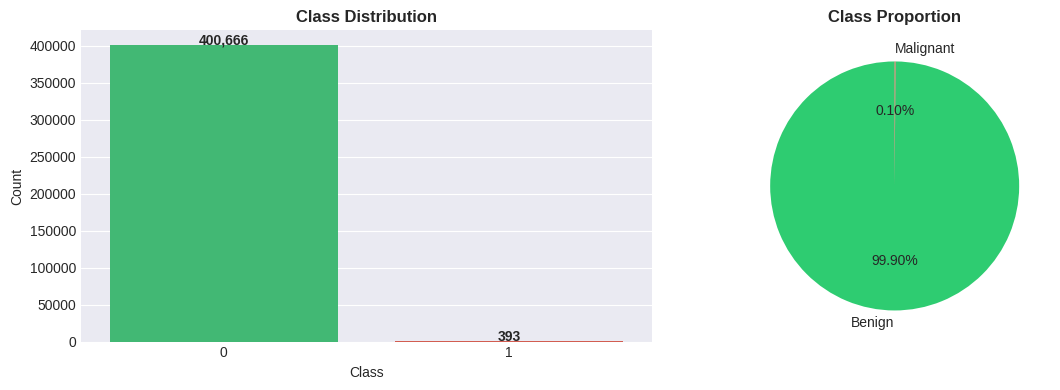


10 columns with missing values


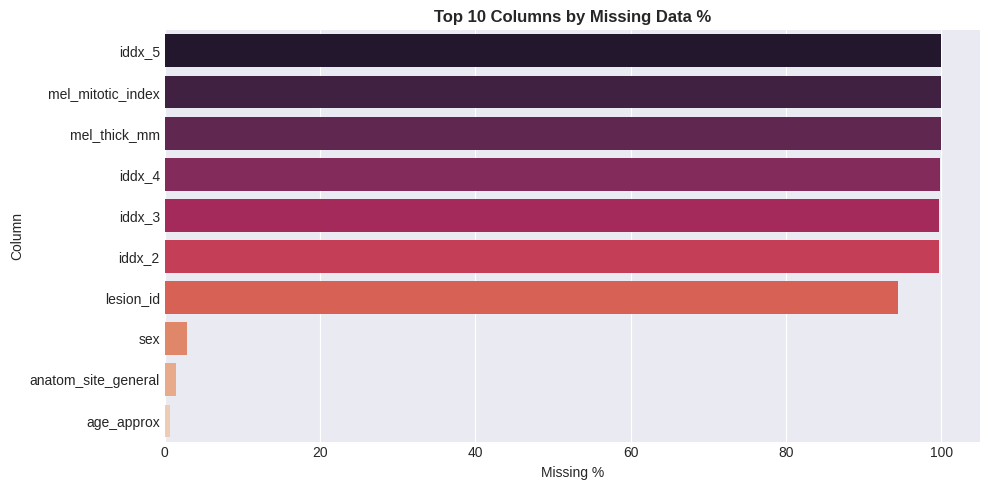


Top 5 Correlated Features:
tbp_lv_areaMM2            0.045139
tbp_lv_perimeterMM        0.036188
tbp_lv_minorAxisMM        0.035757
clin_size_long_diam_mm    0.032682
tbp_lv_stdLExt            0.026084
Name: target, dtype: float64


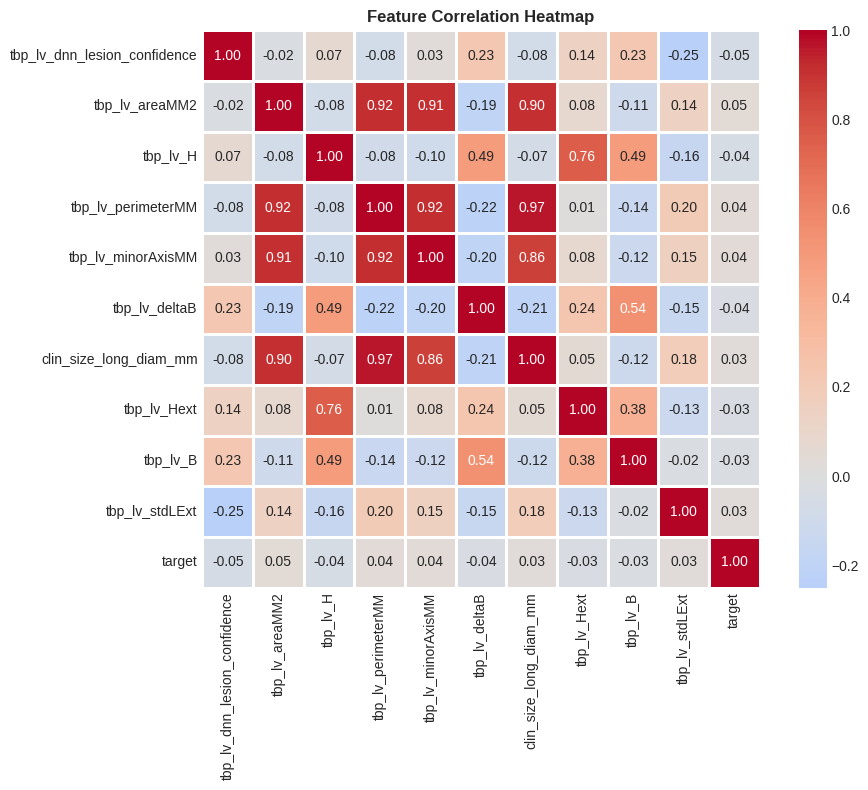


✓ EDA complete


In [4]:
"""
EDA
"""

train_meta = pd.read_csv(TRAIN_META_PATH)
test_meta = pd.read_csv(TEST_META_PATH)

print("="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)
print(f"Train samples: {len(train_meta):,} | Test samples: {len(test_meta):,}")

# Class distribution
if 'target' in train_meta.columns:
    target_counts = train_meta['target'].value_counts()
    target_pct = (target_counts / len(train_meta)) * 100
    imbalance_ratio = target_counts[0] / target_counts[1]

    print(f"\nClass Distribution:")
    print(f"  Benign (0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
    print(f"  Malignant (1): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
    print(f"  Imbalance Ratio: {imbalance_ratio:.1f}:1")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Count plot
    sns.countplot(data=train_meta, x='target', ax=axes[0], palette=['#2ecc71', '#e74c3c'])
    axes[0].set_title('Class Distribution', fontweight='bold')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    for i, (k, v) in enumerate(target_counts.items()):
        axes[0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

    # Pie chart
    axes[1].pie(target_counts, labels=['Benign', 'Malignant'],
                autopct='%1.2f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
    axes[1].set_title('Class Proportion', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Missing values
missing = train_meta.isnull().sum()
missing_pct = (missing / len(train_meta)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing': missing.values,
    'Percent': missing_pct.values
}).query('Missing > 0').sort_values('Missing', ascending=False)

if len(missing_df) > 0:
    print(f"\n{len(missing_df)} columns with missing values")

    # Visualize top missing
    top_missing = missing_df.head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_missing, x='Percent', y='Column', palette='rocket')
    plt.title('Top 10 Columns by Missing Data %', fontweight='bold')
    plt.xlabel('Missing %')
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing values")

# Feature correlations
numeric_cols = train_meta.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numeric_cols:
    numeric_cols.remove('target')

if 'target' in train_meta.columns and len(numeric_cols) > 0:
    correlations = train_meta[numeric_cols + ['target']].corr()['target'].drop('target')
    correlations = correlations.sort_values(ascending=False)

    print(f"\nTop 5 Correlated Features:")
    print(correlations.head(5))

    # Heatmap
    top_features = list(correlations.abs().nlargest(10).index) + ['target']
    plt.figure(figsize=(10, 8))
    sns.heatmap(train_meta[top_features].corr(), annot=True, fmt='.2f',
                cmap='coolwarm', center=0, square=True, linewidths=1)
    plt.title('Feature Correlation Heatmap', fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n✓ EDA complete")

In [5]:
"""
Data Preprocessing
"""

numeric_cols = train_meta.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_meta.select_dtypes(include=['object']).columns.tolist()

if 'target' in numeric_cols:
    numeric_cols.remove('target')

# Impute numeric with median
for col in numeric_cols:
    if train_meta[col].isnull().sum() > 0:
        median_val = train_meta[col].median()
        train_meta[col].fillna(median_val, inplace=True)
        if col in test_meta.columns:
            test_meta[col].fillna(median_val, inplace=True)

# Impute categorical with mode
for col in categorical_cols:
    if train_meta[col].isnull().sum() > 0:
        mode_val = train_meta[col].mode()[0] if not train_meta[col].mode().empty else 'Unknown'
        train_meta[col].fillna(mode_val, inplace=True)
        if col in test_meta.columns:
            test_meta[col].fillna(mode_val, inplace=True)

train_missing = train_meta.isnull().sum().sum()
test_missing = test_meta.isnull().sum().sum()

print("Missing Values After Imputation:")
print(f"  Train: {train_missing} | Test: {test_missing}")
print("✓ Preprocessing complete")

Missing Values After Imputation:
  Train: 0 | Test: 0
✓ Preprocessing complete


In [6]:
"""
Class Imbalance Handling

Strategy Selection:
1 = Moderate (50:1) - Good balance for 1000:1+ ratios
2 = Aggressive (25:1) - Maximum minority class focus
3 = Conservative (100:1) - Preserves more majority samples
4 = Minimal (200:1) - Near-full data with strong weights
"""

# Configuration
SELECTED_STRATEGY = 1  # Change this: 1, 2, 3, or 4
VAL_SPLIT = 0.2
RANDOM_STATE = 42

# Separate classes
malignant = train_meta[train_meta['target'] == 1].copy()
benign = train_meta[train_meta['target'] == 0].copy()

original_ratio = len(benign) / len(malignant)
print(f"Original Distribution: {len(benign):,} benign | {len(malignant):,} malignant")
print(f"Original Ratio: {original_ratio:.1f}:1\n")

# Stratified split
np.random.seed(RANDOM_STATE)

malignant_shuffled = malignant.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
n_val_malignant = int(len(malignant) * VAL_SPLIT)
val_malignant = malignant_shuffled.iloc[:n_val_malignant]
train_malignant = malignant_shuffled.iloc[n_val_malignant:]

benign_shuffled = benign.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
n_val_benign = int(len(benign) * VAL_SPLIT)
val_benign = benign_shuffled.iloc[:n_val_benign]
train_benign = benign_shuffled.iloc[n_val_benign:]

# Strategy definitions
strategies = {
    1: {'ratio': 50, 'name': 'moderate_50to1', 'description': 'Moderate (50:1)'},
    2: {'ratio': 25, 'name': 'aggressive_25to1', 'description': 'Aggressive (25:1)'},
    3: {'ratio': 100, 'name': 'conservative_100to1', 'description': 'Conservative (100:1)'},
    4: {'ratio': 200, 'name': 'minimal_200to1', 'description': 'Minimal (200:1)'}
}

strategy_config = strategies[SELECTED_STRATEGY]
target_ratio = strategy_config['ratio']
n_train_benign = len(train_malignant) * target_ratio

# Sample benign class
train_benign_sampled = train_benign.sample(
    n=min(n_train_benign, len(train_benign)),
    random_state=RANDOM_STATE
)

# Create balanced sets
train_balanced = pd.concat([train_benign_sampled, train_malignant])
train_balanced = train_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

val_balanced = pd.concat([val_benign, val_malignant])
val_balanced = val_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=train_balanced['target']
)

CLASS_WEIGHTS = {
    0: float(class_weights[0]),
    1: float(class_weights[1])
}

# Prepare metadata
train_balanced['image_path'] = train_balanced['isic_id'].astype(str)
train_balanced['label'] = train_balanced['target'].map({0: 'benign', 1: 'malignant'})
val_balanced['image_path'] = val_balanced['isic_id'].astype(str)
val_balanced['label'] = val_balanced['target'].map({0: 'benign', 1: 'malignant'})

# Save
train_balanced.to_csv('/content/train_metadata_balanced.csv', index=False)
val_balanced.to_csv('/content/val_metadata_balanced.csv', index=False)

# Summary
n_benign_train = (train_balanced['target'] == 0).sum()
n_malignant_train = (train_balanced['target'] == 1).sum()
train_ratio = n_benign_train / n_malignant_train

print(f"Strategy: {strategy_config['description']}")
print(f"\nTraining Set:")
print(f"  Total: {len(train_balanced):,}")
print(f"  Benign: {n_benign_train:,} | Malignant: {n_malignant_train:,}")
print(f"  Ratio: {train_ratio:.1f}:1")
print(f"\nValidation Set:")
print(f"  Total: {len(val_balanced):,}")
print(f"  Benign: {(val_balanced['target']==0).sum():,} | Malignant: {(val_balanced['target']==1).sum():,}")
print(f"\nClass Weights:")
print(f"  Benign: {CLASS_WEIGHTS[0]:.4f} | Malignant: {CLASS_WEIGHTS[1]:.4f}")

# Store config
TRAIN_META_PATH = '/content/train_metadata_balanced.csv'
VAL_META_PATH = '/content/val_metadata_balanced.csv'
N_TRAIN_SAMPLES = len(train_balanced)
N_VAL_SAMPLES = len(val_balanced)
STRATEGY_NAME = strategy_config['name']

print("\n✓ Class balancing complete")

Original Distribution: 400,666 benign | 393 malignant
Original Ratio: 1019.5:1

Strategy: Moderate (50:1)

Training Set:
  Total: 16,065
  Benign: 15,750 | Malignant: 315
  Ratio: 50.0:1

Validation Set:
  Total: 80,211
  Benign: 80,133 | Malignant: 78

Class Weights:
  Benign: 0.5100 | Malignant: 25.5000

✓ Class balancing complete


Extracting images from HDF5...
Training: 16,065/16,065 extracted
Validation: 80,211/80,211 extracted

Sample Images:


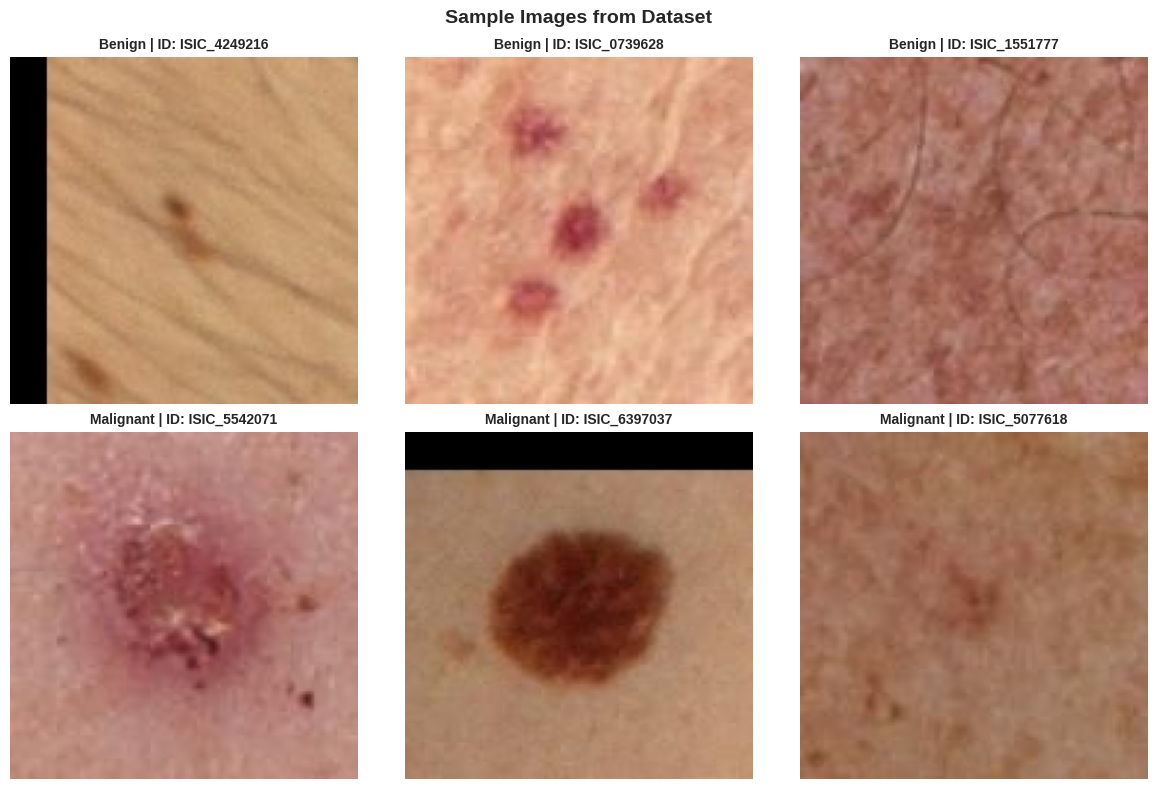


✓ Image extraction complete


In [7]:
"""
Image Extraction & Visualization
"""

import cv2

# Setup directories
TRAIN_IMG_DIR = '/content/train_images'
VAL_IMG_DIR = '/content/val_images'
os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(VAL_IMG_DIR, exist_ok=True)

def extract_images(hdf5_path, df, output_dir):
    """Extract images from HDF5 to directory"""
    extracted = 0
    failed = 0

    with h5py.File(hdf5_path, 'r') as hdf:
        for isic_id in df['isic_id']:
            try:
                key = str(isic_id)
                if key in hdf:
                    img_bytes = hdf[key][()]
                    nparr = np.frombuffer(img_bytes, np.uint8)
                    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                    if img is not None:
                        cv2.imwrite(f'{output_dir}/{isic_id}.jpg', img)
                        extracted += 1
                    else:
                        failed += 1
                else:
                    failed += 1
            except Exception:
                failed += 1

    return extracted, failed

# Extract images
print("Extracting images from HDF5...")
train_extracted, train_failed = extract_images(
    TRAIN_HDF5_PATH, train_balanced, TRAIN_IMG_DIR
)
val_extracted, val_failed = extract_images(
    TRAIN_HDF5_PATH, val_balanced, VAL_IMG_DIR
)

print(f"Training: {train_extracted:,}/{len(train_balanced):,} extracted")
print(f"Validation: {val_extracted:,}/{len(val_balanced):,} extracted")

# Display sample images
def display_samples(df, img_dir, n_samples=6):
    """Display random sample images from each class"""
    benign_samples = df[df['target'] == 0].sample(n=min(n_samples//2, len(df[df['target']==0])), random_state=42)
    malignant_samples = df[df['target'] == 1].sample(n=min(n_samples//2, len(df[df['target']==1])), random_state=42)
    samples = pd.concat([benign_samples, malignant_samples])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for idx, (_, row) in enumerate(samples.iterrows()):
        if idx >= n_samples:
            break

        img_path = f"{img_dir}/{row['isic_id']}.jpg"
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[idx].imshow(img)
            axes[idx].set_title(f"{row['label'].capitalize()} | ID: {row['isic_id']}",
                              fontsize=10, fontweight='bold')
            axes[idx].axis('off')

    plt.suptitle('Sample Images from Dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nSample Images:")
display_samples(train_balanced, TRAIN_IMG_DIR)

print("\n✓ Image extraction complete")

In [8]:
"""
Data Generators
"""

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Organize images into class directories
train_class_dir = '/content/train_organized'
val_class_dir = '/content/val_organized'

for base_dir in [train_class_dir, val_class_dir]:
    os.makedirs(f"{base_dir}/benign", exist_ok=True)
    os.makedirs(f"{base_dir}/malignant", exist_ok=True)

# Copy training images
copied_train = 0
for _, row in train_balanced.iterrows():
    src = f"{TRAIN_IMG_DIR}/{row['isic_id']}.jpg"
    dst = f"{train_class_dir}/{row['label']}/{row['isic_id']}.jpg"
    if os.path.exists(src):
        shutil.copy(src, dst)
        copied_train += 1

# Copy validation images
copied_val = 0
for _, row in val_balanced.iterrows():
    src = f"{VAL_IMG_DIR}/{row['isic_id']}.jpg"
    dst = f"{val_class_dir}/{row['label']}/{row['isic_id']}.jpg"
    if os.path.exists(src):
        shutil.copy(src, dst)
        copied_val += 1

print(f"Organized: Train={copied_train:,} | Val={copied_val:,}")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(
    train_class_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['benign', 'malignant'],
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    val_class_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['benign', 'malignant'],
    shuffle=False
)

STEPS_PER_EPOCH = train_gen.samples // BATCH_SIZE
VALIDATION_STEPS = val_gen.samples // BATCH_SIZE

print(f"\nData Generators Ready:")
print(f"  Train: {train_gen.samples:,} samples | {STEPS_PER_EPOCH} steps/epoch")
print(f"  Val: {val_gen.samples:,} samples | {VALIDATION_STEPS} val steps")
print("✓ Generators configured")

Organized: Train=16,065 | Val=80,211
Found 16065 images belonging to 2 classes.
Found 80211 images belonging to 2 classes.

Data Generators Ready:
  Train: 16,065 samples | 502 steps/epoch
  Val: 80,211 samples | 2506 val steps
✓ Generators configured


In [ ]:
"""
Model Training with Focal Loss
"""

import tensorflow as tf

# Focal Loss for class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for handling class imbalance
    gamma: focusing parameter (higher = more focus on hard examples)
    alpha: class balancing parameter
    """
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        focal_weight_1 = alpha * K.pow(1 - pt_1, gamma)
        focal_weight_0 = (1 - alpha) * K.pow(pt_0, gamma)

        loss_1 = -focal_weight_1 * K.log(pt_1)
        loss_0 = -focal_weight_0 * K.log(1 - pt_0)

        return K.mean(loss_1 + loss_0)
    return loss_fn

# Build model with MobileNetV2
print("Building model architecture...")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

print(f"Model parameters: {model.count_params():,}")

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve='PR', name='auc_pr'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Phase 1: Train top layers
print("\n" + "="*70)
print("PHASE 1: Training top layers (20 epochs)")
print("="*70)

callbacks_p1 = [
    EarlyStopping(monitor='val_auc_pr', patience=7, mode='max',
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_auc_pr', factor=0.5, patience=3,
                      min_lr=1e-7, mode='max', verbose=1),
    ModelCheckpoint('/content/phase1_best.keras', monitor='val_auc_pr',
                    save_best_only=True, mode='max', verbose=0)
]

history_p1 = model.fit(
    train_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_gen,
    validation_steps=VALIDATION_STEPS,
    epochs=20,
    callbacks=callbacks_p1,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

best_p1 = np.argmax(history_p1.history['val_auc_pr'])
print(f"\nPhase 1 Best (epoch {best_p1+1}): AUC-PR={history_p1.history['val_auc_pr'][best_p1]:.4f}")

# Phase 2: Fine-tune
print("\n" + "="*70)
print("PHASE 2: Fine-tuning last 30 layers (15 epochs)")
print("="*70)

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve='PR', name='auc_pr'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

callbacks_p2 = [
    EarlyStopping(monitor='val_auc_pr', patience=5, mode='max',
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_auc_pr', factor=0.5, patience=2,
                      min_lr=1e-8, mode='max', verbose=1),
    ModelCheckpoint('/content/phase2_best.keras', monitor='val_auc_pr',
                    save_best_only=True, mode='max', verbose=0)
]

history_p2 = model.fit(
    train_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_gen,
    validation_steps=VALIDATION_STEPS,
    epochs=15,
    callbacks=callbacks_p2,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

best_p2 = np.argmax(history_p2.history['val_auc_pr'])
print(f"\nPhase 2 Best (epoch {best_p2+1}): AUC-PR={history_p2.history['val_auc_pr'][best_p2]:.4f}")

# Combine histories
history_combined = {k: history_p1.history[k] + history_p2.history[k]
                   for k in history_p1.history.keys()}
phase1_epochs = len(history_p1.history['loss'])

# Visualize training
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = [('loss', 'Loss'), ('auc_pr', 'AUC-PR'),
           ('recall', 'Recall'), ('precision', 'Precision')]

for ax, (key, title) in zip(axes.flatten(), metrics):
    ax.plot(history_combined[key], label='Train', linewidth=2)
    ax.plot(history_combined[f'val_{key}'], label='Val', linewidth=2)
    ax.axvline(x=phase1_epochs, color='red', linestyle='--',
               label='Phase 2', alpha=0.7)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Two-Phase Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

best_epoch = np.argmax(history_combined['val_auc_pr'])
print(f"\nBest Overall: Epoch {best_epoch+1} | AUC-PR={history_combined['val_auc_pr'][best_epoch]:.4f}")
print("✓ Training complete")

Building model architecture...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model parameters: 2,618,945

PHASE 1: Training top layers (20 epochs)
Epoch 1/20
202/502 ━━━━━━━━━━━━━━━━━━━━ 2:20 467ms/step - accuracy: 0.8938 - auc_pr: 0.0224 - loss: 0.0707 - precision: 0.0198 - recall: 0.0741